# Quoridor BGA stats

A little over 200k Quoridor game records downloaded from Board Game Arena. I tried to be nice and asked BGA, but they didn't get back to me, which I took as a permission to scrape their website. They have since introduced replay limits, making it harder to scrape.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_json("../data/bga-games-info.json")
data.count()["game_id"]

218784

## Players

Let's see how many players we have...

In [3]:
played_as_x = data["x_name"].value_counts()
played_as_o = data["o_name"].value_counts()
games_played = played_as_x.combine(played_as_o, lambda x1, x2: x1 + x2, 0).sort_values(0, False)
games_played.name = "games_played"
games_played.count()

45091

Let's see the most active players and the activity distribution:

In [4]:
games_played.head()

djkais        7474
MatMat8501    4729
ia18          4177
Joao123       3679
fischietto    3008
Name: games_played, dtype: int64

In [5]:
games_played.describe([.5, .75, .9, .95, .99])[["50%", "75%", "90%", "95%", "99%"]]

50%      2.0
75%      5.0
90%     12.0
95%     24.0
99%    124.0
Name: games_played, dtype: float64

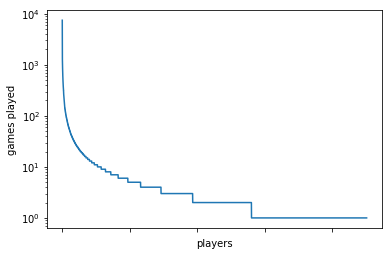

In [6]:
plot = games_played.plot(logy=True)
plot.set_ylabel("games played")
plot.set_xlabel("players")
pass

We have some active players, and predictably there's a couple of players playing a lot of games, and lots of players who have only played one or two games. Playing 12 games puts one in the 10% of the most active players.

Let's look at the active players further and check how the win ratio changes depending on whether the player goes first:

In [7]:
x_won = data[data.winner == "x"]["x_name"].value_counts()
x_won.name = "won_as_starting_player"
o_won = data[data.winner == "o"]["o_name"].value_counts()
o_won.name = "won_as_last_player"

x_lost = data[data.winner == "o"]["x_name"].value_counts()
x_lost.name = "lost_as_starting_player"
o_lost = data[data.winner == "x"]["o_name"].value_counts()
o_lost.name = "lost_as_last_player"

In [8]:
players = pd.DataFrame(games_played)
players = players.join(x_won)
players = players.join(o_won)
players = players.join(x_lost)
players = players.join(o_lost)
players = players.fillna(0).astype(int)

players["start_winratio"] = players["won_as_starting_player"] / (players["won_as_starting_player"] + players["lost_as_starting_player"])
players["last_winratio"] = players["won_as_last_player"] / (players["won_as_last_player"] + players["lost_as_last_player"])
players.head()

,games_played,won_as_starting_player,won_as_last_player,lost_as_starting_player,lost_as_last_player,start_winratio,last_winratio
djkais,7474,3013,2721,766,970,0.797301,0.737199
MatMat8501,4729,2087,1938,324,367,0.865616,0.840781
ia18,4177,1255,1153,828,933,0.602496,0.552733
Joao123,3679,1419,1287,475,496,0.749208,0.721817
fischietto,3008,1316,1255,201,235,0.867502,0.842282


Apparently, going first gives an advantage, but not a huge advantage.

Let's see the won/lost ratio and overall win ratio.

In [9]:
players["won"] = players["won_as_starting_player"] + players["won_as_last_player"]
players["lost"] = players["lost_as_starting_player"] + players["lost_as_last_player"]
players["finished"] = players["won"] + players["lost"]
players["winratio"] = players["won"] / players["finished"]

players[["games_played", "finished", "won", "lost", "winratio"]].head()

,games_played,finished,won,lost,winratio
djkais,7474,7470,5734,1736,0.767604
MatMat8501,4729,4716,4025,691,0.853478
ia18,4177,4169,2408,1761,0.577597
Joao123,3679,3677,2706,971,0.735926
fischietto,3008,3007,2571,436,0.855005


Looks like some games are missing results...

In [10]:
data[data["winner"] == ""].count()["game_id"]

307

Not too bad. Let's see most successful players with more than 100 games:

In [11]:
players[["finished", "won", "lost", "winratio"]][players["finished"] > 100].sort_values(by=["winratio"], ascending=False).head(8)

,finished,won,lost,winratio
deszczyk,504,489,15,0.970238
aley,155,146,9,0.941935
Tejo,172,150,22,0.872093
paulat,132,113,19,0.856061
fischietto,3007,2571,436,0.855005
MatMat8501,4716,4025,691,0.853478
kim81,102,86,16,0.843137
kragonn,140,118,22,0.842857


Practice makes perfect - two of the players from the top 5 most games played appear in top 10 for the win ratio. Let's see average win ratio by games played...

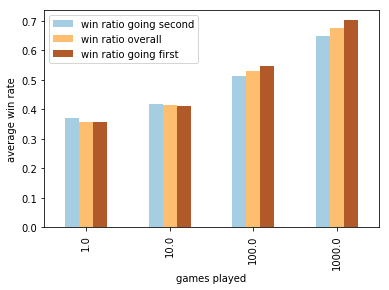

In [12]:
players["group"] = 10 ** np.floor(np.log10(games_played))

win_ratios = players.groupby(players["group"]).mean()[["last_winratio", "winratio", "start_winratio"]]
plot = win_ratios.plot(kind="bar", colormap="Paired")
plot.set_ylabel("average win rate")
plot.set_xlabel("games played")
plot.legend(["win ratio going second", "win ratio overall", "win ratio going first"])
pass